# Compare Arima results from Skforecast, pmdarima and statsforecast

In [104]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)
import skforecast

print(skforecast.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/joaquin/Documents/GitHub/skforecast
0.20.0


In [ ]:
import numpy as np
import pandas as pd
from pmdarima import ARIMA as pmdarima_ARIMA
from skforecast.stats import Arima as skf_Arima
from statsforecast.models import ARIMA as statsforecast_Arima
import warnings
import timeit

In [106]:
# Data sets
# ==============================================================================

datasets = {}

air_passengers = pd.Series(np.array([
    112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118,
    115, 126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140,
    145, 150, 178, 163, 172, 178, 199, 199, 184, 162, 146, 166,
    171, 180, 193, 181, 183, 218, 230, 242, 209, 191, 172, 194,
    196, 196, 236, 235, 229, 243, 264, 272, 237, 211, 180, 201,
    204, 188, 235, 227, 234, 264, 302, 293, 259, 229, 203, 229,
    242, 233, 267, 269, 270, 315, 364, 347, 312, 274, 237, 278,
    284, 277, 317, 313, 318, 374, 413, 405, 355, 306, 271, 306,
    315, 301, 356, 348, 355, 422, 465, 467, 404, 347, 305, 336,
    340, 318, 362, 348, 363, 435, 491, 505, 404, 359, 310, 337,
    360, 342, 406, 396, 420, 472, 548, 559, 463, 407, 362, 405,
    417, 391, 419, 461, 472, 535, 622, 606, 508, 461, 390, 432], dtype=np.float64),
    name="air_passengers"
)
datasets['air_passengers'] = {'data': air_passengers, 'seasonal_periods': 12, 'order': (0, 1, 1), 'seasonal_order': (0, 1, 1), 'steps_ahead': 24}

monthly_data = pd.Series(np.array([
    156.83145573290403, 198.01090980146668, 207.9294519090584, 192.50881106335353, 143.88220402427257, 
    109.61247461878796, 51.02783684004386, 28.830574625122402, 33.3467665506287, 23.522525664450917, 48.66533667747763,
    107.43274507456638, 165.64013486015855, 200.15344049878215, 211.5155166091762, 202.1730030845587, 149.413779424248, 
    114.8274687399386, 60.3144164424087, 29.459673433893094, 5.0319329715038, 25.255954513588897, 69.46784873284764,
    118.75490591398581, 138.50191829826542, 215.75333240194234, 220.07545455740012, 217.15814111236023, 191.90129990488526,
    108.8088676939804, 54.29519820628114, 37.54688841628041, -1.2454449934178413, 34.66284406168156, 48.04912269201285,
    107.40050982214626]),
    name='monthly_data')
datasets['monthly_data'] = {'data': monthly_data, 'seasonal_periods': 12, 'order': (1, 1, 1), 'seasonal_order': (1, 1, 1), 'steps_ahead': 24}

quarterly_data = pd.Series(np.array([
    255.5207840618145, 87.99560565039364, -50.22197639689352, 100.31688949671437, 242.67651141877238, 100.52525241597803,
    -46.08957390612448, 95.35610392578661, 261.43281111884124, 105.959923879395, -52.332682335543794, 110.88162945765853, 257.26397049987094, 
     101.13289060185168, -62.98234513672319, 87.3748290530375, 263.8323849444473, 108.91573342476657, -61.783202628041785, 110.22246835230273, 
     245.01319786445208, 110.9737910820319, -53.64130850287849, 113.70236140280312]),
    name='quarterly_data'
)
datasets['quarterly_data'] = {'data': quarterly_data, 'seasonal_periods': 4, 'order': (1, 1, 1), 'seasonal_order': (1, 1, 1), 'steps_ahead': 8}

daily_data = pd.Series(np.array([
    1749.349184518034, 2012.0710580391506, 1493.0154891668535, 462.047082761232, 50.865783828344284, 460.06967664987263, 1046.5098920989092, 
    1732.6813259649934, 2044.4650005528904, 1457.6653933204234, 656.3330212062435, 53.85076527512874, 302.9618975758385, 1000.6310493662936, 
    1806.1705543691553, 2074.918150381484, 1471.6715561040307, 681.5663548831715, 55.187666687122146, 117.84251942586233, 1030.210501819249, 
    1760.1321040466987, 2097.794745263811, 1580.353318797828, 490.2946924710491, -133.83617211844629, 321.1748761486958, 1026.0687262646018, 
    1831.4742310147008, 2111.9472142549675, 1301.6816855005184, 636.8966872740124, 67.57821840581548, -4.331952059498036, 974.7489363552428, 
    1624.1873281795063]),
    name='daily_data'
)
datasets['daily_data'] = {'data': daily_data, 'seasonal_periods': 7, 'order': (1, 1, 1), 'seasonal_order': (1, 1, 1), 'steps_ahead': 14}

hourly_data = pd.Series(np.array([
    71.37918135156875, 85.8543432348506, 79.3066299785248, 88.19294702225602, 74.52408618413598, 84.38330781641443, 115.56079010814668, 102.40505779052614, 
    87.25420321325205, 80.38382892783665, 72.13377425796332, 46.731426724867745, 30.549222541945262, 22.478309134678916, 5.298309941546334, 6.5835758431834215, -14.532761281188694,
    -13.752146188889045, 11.654961659112109, 23.679607106346317, 26.956866249535913, 52.26239608957695, 50.80004597793651, 60.94287490127781, 48.83010084842864, 86.68838987000643, 
    84.05495480060645, 86.06584416580166, 111.4879720574784, 92.44965808952739, 103.6212930503394, 96.27502856687921, 86.05268297846618, 62.85164253224801, 72.0989871692978, 
    52.06960406236867, 33.237540663475635, 22.915531503795766, 25.096479486631594, 24.577070770996464, 4.03716379051701, 16.729657793875337, 17.008242179578367, 32.82357605387345, 
    17.97418533364006, 39.860438966124455, 36.07701429609706, 41.82545719386261, 62.462055622253864, 97.20672004658493, 83.0182777674507, 99.23832608858793, 121.29165042874155, 
    104.19097850654907, 104.61251220128679, 104.72392728847008, 94.74827365170356, 94.24573313491871, 66.77858338924341, 42.585482039769644, 37.32753690990771, 51.671441510808414, 
    18.20823249084842, 26.42778376467034, 3.0398876707858973, 19.466122730029763, 19.123398367257554, 16.125321333077846, 15.29886562062449, 25.74054170566481, 36.27166701289651,
    57.844144408882755, 81.95238665680269, 89.0832254833273, 100.38285256092303, 108.50090948549702, 116.68981514762598, 107.71994371650905, 101.54405738576708, 93.53370125543341,
    90.96766772636944, 99.17768408897605, 72.12136512544116, 61.731781256486386, 44.29800236372274, 44.29479716079315, 19.94448750712072, 28.79830754108969, 1.0201183482837113,
    3.219090053820035, 14.044953721984703, 14.622909376186058, 24.259667824694663, 13.590057683840271, 51.36043164778454, 57.392081392764894]),
    name='hourly_data'
)
datasets['hourly_data'] = {'data': hourly_data, 'seasonal_periods': 24, 'order': (1, 1, 1), 'seasonal_order': (1, 1, 1), 'steps_ahead': 40}

no_seasonal_data = pd.Series(np.array([
    97.6050489407213, 115.66030359421944, 109.55208728844406, 91.65541470371792, 85.24607237085254, 89.6443661655059, 97.01577728014611, 
    104.33860351448578, 104.28238560313135, 111.58948171956203, 99.80718547190561, 97.25530601257535, 92.42851598447066, 114.78920397777841, 
    103.4567675295882, 114.39737849488006, 103.95460179432608, 106.86776724365077, 100.50976902283695, 100.3304086154929, 110.96348348012472, 
    112.00890359198776, 103.64812953321086, 90.26853823578205]),
    name='no_seasonal_data'
)
datasets['no_seasonal_data'] = {'data': no_seasonal_data, 'seasonal_periods': 1, 'order': (2, 1, 2), 'seasonal_order': (0, 0, 0), 'steps_ahead': 10}

strong_seasonal = pd.Series(np.array([
    202.7, 270.1, 313.1, 273.5, 209.7, 112.3, 5.0, -75.0, -109.4, -75.3, -16.6, 100.1, 201.6, 266.2, 297.9, 270.6, 200.0, 90.4, 
    -8.1, -64.5, -85.8, -74.8, 5.4, 88.5, 192.7, 264.3, 285.3, 284.2, 195.7, 98.9, 5.0, -55.7, -99.7, -66.1, 1.4, 99.3, 195.8, 270.7, 290.8, 277.1, 
    205.7, 103.1, 1.3, -77.3, -95.2, -84.1, -14.2, 98.5, 209.4, 276.4, 296.1, 267.0, 205.8, 103.6, 11.4, -69.5, -94.4, -76.1, 11.3, 99.9, 201.6, 
    258.8, 299.5, 279.8, 191.2, 76.2, 4.1, -65.9, -99.7, -89.8, 12.6, 82.8, 203.7, 289.3, 299.4, 284.6, 190.8, 98.1, 13.9, -67.1, -117.6, -66.4, 
    1.3, 94.8, 226.8, 273.9, 319.0, 280.4, 199.6, 113.5, 4.6, -62.3, -102.2, -69.4, 0.2, 105.3, 215.0, 264.6, 277.7, 262.5, 182.3, 112.6, -1.8, -71.6,
    -90.0, -80.8, -6.0, 107.9, 209.8, 262.3, 301.1, 273.4, 189.8, 96.6, 1.8, -78.5, -101.8, -52.8, -4.6, 100.1, 209.7, 278.7, 308.4, 268.1, 195.3, 
    114.5, -12.0, -73.4, -117.9, -76.1, 6.3, 103.6, 215.9, 262.3, 280.3, 271.4, 221.6, 104.7, -20.0, -81.7, -86.0, -70.8, -9.8, 94.4, 205.7, 283.2, 
    287.0, 244.5, 198.5, 89.3, 2.1, -68.8, -92.9, -51.9, 1.7, 97.8, 185.7, 270.3, 292.2, 263.7, 216.4, 102.4, 7.4, -79.3, -104.0, -71.8, 4.2, 97.5,
    212.6, 268.3, 304.9, 253.5, 201.0, 114.5, 5.3, -90.1, -108.7, -81.5, 0.6, 90.7, 196.2, 284.9, 288.6, 291.5, 200.8, 104.5, -1.8, -69.9, -99.4, 
    -80.4, -10.1, 104.0, 185.9, 286.6, 292.4, 275.0, 205.9, 100.4, -6.6, -84.7]),
    name='strong_seasonal'
)
datasets['strong_seasonal'] = {'data': strong_seasonal, 'seasonal_periods': 12, 'order': (0, 1, 1), 'seasonal_order': (0, 1, 1), 'steps_ahead': 24}

# Multiple seasonal periods (simulate daily data with both weekly and annual patterns)
multi_seasonal = pd.Series(np.array([
    102.9, 101.1, 100.4, 91.5, 77.2, 104.5, 108.2, 101.4, 105.0, 105.7, 84.5, 112.6, 83.9, 86.0, 96.9, 105.7, 113.5, 102.2, 95.5, 
    96.1, 102.6, 107.2, 95.8, 103.8, 88.1, 124.5, 101.6, 120.7, 117.4, 124.3, 127.8, 110.9, 96.8, 116.7, 121.6, 99.4, 113.9, 93.8, 99.5, 93.9, 136.5, 
    89.9, 115.2, 106.7, 109.5, 98.6, 107.3, 98.2, 98.7, 106.6, 118.0, 110.1, 109.8, 126.1, 97.4, 107.0, 90.6, 122.1, 118.4, 92.6, 102.7, 123.0, 103.4,
    104.1, 119.2, 94.3, 115.0, 106.1, 110.9, 118.9, 108.5, 108.8, 111.1, 117.0, 94.2, 109.9, 90.9, 123.4, 118.7, 104.8, 112.8, 84.9, 94.0, 122.1, 114.5,
    109.1, 127.4, 118.4, 98.1, 114.8, 110.0, 82.3, 101.8, 107.8, 114.7, 100.6, 100.0, 95.8, 102.6, 115.4, 117.6, 111.6, 96.2, 103.1, 98.0, 94.0, 141.0, 
    113.0, 110.5, 96.9, 99.5, 107.2, 115.3, 109.2, 101.2, 88.3, 114.0, 125.6, 123.3, 107.2, 125.5, 115.1, 113.4, 130.2, 106.4, 105.4, 99.9, 124.4, 113.4,
    116.4, 118.6, 115.0, 108.0, 105.4, 125.8, 116.5, 103.9, 105.5, 107.2, 110.9, 94.7, 126.8, 120.4, 98.1, 106.8, 104.7, 120.0, 108.5, 122.3, 108.4, 107.6,
    112.2, 106.8, 123.1, 114.7, 111.3, 109.9, 122.0, 128.6, 119.7, 115.2, 126.1, 118.0, 125.4, 118.9, 115.7, 106.1, 114.6, 123.2, 117.8, 136.7, 114.1, 96.4,
    96.3, 108.2, 106.8, 99.4, 120.6, 121.3, 104.2, 119.8, 123.9, 127.1, 131.1, 111.3, 138.9, 115.6, 107.1, 116.5, 118.9, 102.4, 125.9, 121.1, 125.0, 114.2, 
    120.6, 112.0, 125.1, 118.6, 149.6, 137.7, 128.8, 110.3, 131.4, 137.5, 113.2, 115.2, 120.9, 113.4, 116.5, 111.7, 137.5, 116.9, 125.5, 117.4, 110.8, 132.9, 
    130.8, 128.0, 123.7, 150.9, 100.2, 122.5, 127.9, 114.3, 111.0, 113.7, 121.8, 117.2, 120.2, 112.6, 121.8, 123.8, 130.2, 113.2, 118.6, 123.6, 111.0, 114.2, 
    127.7, 128.6, 122.7, 132.1, 119.6, 139.3, 119.7, 126.1, 119.8, 119.1, 105.3, 136.2, 102.1, 149.6, 122.7, 117.0, 115.5, 135.6, 120.2, 127.9, 128.4, 133.0, 
    141.8, 139.1, 114.5, 121.4, 126.5, 119.2, 121.5, 137.9, 117.2, 129.0, 133.2, 109.2, 128.1, 145.4, 130.3, 123.6, 130.6, 118.1, 124.6, 115.0, 128.2, 127.6, 
    121.1, 139.0, 130.7, 137.1, 109.9, 134.3, 131.1, 145.8, 138.3, 133.8, 114.6, 132.2, 137.8, 130.2, 132.8, 129.6, 128.3, 127.2, 124.4, 144.8, 135.6, 134.4, 
    118.2, 126.6, 132.3, 135.0, 140.2, 120.9, 149.6, 126.4, 132.8, 124.1, 104.5, 132.4, 156.5, 124.6, 133.5, 132.5, 139.0, 141.3, 136.2, 115.6, 135.4, 150.3, 
    119.6, 129.6, 134.5, 134.0, 122.7, 135.6, 131.5, 142.7, 131.9, 142.8, 146.4, 134.1, 155.4, 132.5, 128.8, 132.9, 141.4, 122.8, 143.1, 134.5, 139.3, 109.9, 
    125.0, 120.6, 151.2, 135.5, 130.6, 134.7, 138.7, 138.0, 137.6, 131.4, 152.6, 143.8, 138.8, 136.2, 125.4, 137.5, 136.3, 128.6, 136.0, 139.7, 125.1, 123.0, 
    139.1, 140.6, 126.7, 143.0, 143.0, 140.3, 134.4, 132.2, 136.8, 133.8, 136.9, 150.0, 151.3, 141.5, 145.4, 139.9, 140.2, 130.9, 144.8, 120.1, 147.6, 126.2, 
    120.2, 138.3, 123.8, 146.6, 144.6, 155.8, 133.8, 137.2, 134.5, 157.1, 136.5, 130.5, 157.3, 144.4, 149.7, 137.2, 144.9, 132.7, 146.9, 170.1, 133.9, 124.5, 
    141.8, 147.5, 127.4, 153.4, 148.0, 133.2, 146.6, 151.7, 151.3, 143.8, 139.5, 151.8, 141.5, 134.6, 145.6, 135.5, 140.1, 138.0, 129.3, 143.8, 160.7, 136.2, 
    138.6, 137.5, 137.0, 145.8, 153.5, 126.4, 126.0, 144.5, 142.7, 149.9, 148.6, 147.2, 147.2, 144.2, 145.0, 146.5, 155.7, 151.6, 132.4, 133.2, 134.5, 142.2,
    151.6, 146.5, 126.8, 158.1, 184.7, 156.3, 155.8, 137.4, 133.9, 156.6, 155.5, 138.2, 152.9, 158.5, 158.8, 148.3, 154.9, 148.1, 157.4, 143.3, 130.2, 139.9, 
    162.8, 148.8, 140.9, 133.7, 137.5, 138.0, 155.5, 160.7, 153.5, 126.4, 138.0, 156.9, 142.7, 157.7, 160.4, 157.1, 131.7, 161.5, 165.8, 161.0, 152.5, 140.8, 
    140.1, 166.2, 147.5, 136.1, 134.7, 148.4, 161.5, 139.6, 152.3, 157.3, 155.9, 138.1, 156.0, 141.0, 131.9, 147.1, 148.8, 148.4, 148.4, 153.6, 150.4, 146.6, 
    168.6, 159.2, 171.7, 147.2, 149.8, 147.8, 155.8, 145.9, 153.3, 158.7, 149.3, 157.7, 171.0, 170.2, 158.7, 169.9, 160.8, 150.8, 147.5, 167.9, 157.2, 154.2, 
    157.6, 141.2, 153.0, 151.6, 144.8, 154.9, 155.1, 158.5, 160.7, 154.4, 142.4, 164.6, 165.9, 155.1, 168.3, 154.9, 166.1, 160.3, 136.6, 160.0, 181.8, 152.4, 
    147.9, 157.9, 163.5, 153.3, 171.1, 163.9, 154.1, 167.5, 150.9, 159.4, 157.6, 175.7, 166.8, 157.6, 152.3, 157.3, 147.8, 164.1, 155.5, 174.6, 156.1, 167.8, 
    143.6, 153.8, 167.6, 178.1, 150.7, 156.8, 152.0, 160.7, 157.3, 158.7, 138.8, 158.8, 144.4, 174.4, 162.0, 154.3, 175.9, 170.8, 157.3, 162.5, 151.0, 156.6, 
    153.0, 164.4, 168.6, 159.2, 149.5, 159.3, 153.6, 165.1, 185.8, 160.5, 166.5, 143.4, 177.7, 153.9, 172.9, 146.9, 161.3, 168.1, 156.4, 149.3, 160.0, 150.3, 
    144.9, 180.3, 142.9, 164.5, 163.6, 153.8, 183.4, 170.0, 157.2, 151.3, 160.0, 150.2, 164.2, 165.1, 163.6, 152.9, 162.5, 156.4, 176.7, 166.5, 160.3, 163.6, 
    175.5, 169.6, 176.6, 192.9, 151.0, 155.5, 165.8, 158.3, 163.6, 193.0, 156.4, 162.9, 165.0, 149.8, 168.6, 172.7, 161.6, 182.4, 169.8, 138.2, 172.4, 180.7, 
    184.0, 175.4, 153.0, 174.0, 188.5, 174.6, 175.8, 156.7, 186.4, 182.3, 179.3, 170.7, 161.9, 160.5, 157.8, 180.1, 154.6, 176.8, 168.6, 156.0, 162.5, 173.2, 
    155.5, 180.7, 180.5, 167.5, 172.9, 174.4, 153.7, 180.9, 145.6, 147.6, 191.7, 178.6, 167.4, 178.6, 176.2, 172.2, 166.9, 185.3, 182.5, 177.0, 152.1, 179.2, 
    163.8, 184.5, 165.4, 189.4, 179.7, 181.8, 186.4]),
    name='multi_seasonal'
)
datasets['multi_seasonal'] = {'data': multi_seasonal, 'seasonal_periods': 7, 'order': (1, 1, 1), 'seasonal_order': (1, 1, 1), 'steps_ahead': 30}

sunspots_data = pd.Series(np.array([
    5., 11., 16., 23., 36., 58., 29., 20., 10., 
    8., 3., 0., 0., 2., 11., 27., 47., 63., 
    60., 39., 28., 26., 22., 11., 21., 40., 78., 
    122., 103., 73., 47., 35., 11., 5., 16., 34., 
    70., 81., 111., 101., 73., 40., 20., 16., 5., 
    11., 22., 40., 60., 80.9, 83.4, 47.7, 47.8, 30.7, 
    12.2, 9.6, 10.2, 32.4, 47.6, 54., 62.9, 85.9, 61.2, 
    45.1, 36.4, 20.9, 11.4, 37.8, 69.8, 106.1, 100.8, 81.6, 
    66.5, 34.8, 30.6, 7., 19.8, 92.5, 154.4, 125.9, 84.8, 
    68.1, 38.5, 22.8, 10.2, 24.1, 82.9, 132., 130.9, 118.1, 
    89.9, 66.6, 60., 46.9, 41., 21.3, 16., 6.4, 4.1, 
    6.8, 14.5, 34., 45., 43.1, 47.5, 42.2, 28.1, 10.1, 
    8.1, 2.5, 0., 1.4, 5., 12.2, 13.9, 35.4, 45.8, 
    41.1, 30.1, 23.9, 15.6, 6.6, 4., 1.8, 8.5, 16.6, 
    36.3, 49.6, 64.2, 67., 70.9, 47.8, 27.5, 8.5, 13.2, 
    56.9, 121.5, 138.3, 103.2, 85.7, 64.6, 36.7, 24.2, 10.7, 
    15., 40.1, 61.5, 98.5, 124.7, 96.3, 66.6, 64.5, 54.1, 
    39., 20.6, 6.7, 4.3, 22.7, 54.8, 93.8, 95.8, 77.2, 
    59.1, 44., 47., 30.5, 16.3, 7.3, 37.6, 74., 139., 
    111.2, 101.6, 66.2, 44.7, 17., 11.3, 12.4, 3.4, 6., 
    32.3, 54.3, 59.7, 63.7, 63.5, 52.2, 25.4, 13.1, 6.8, 
    6.3, 7.1, 35.6, 73., 85.1, 78., 64., 41.8, 26.2, 
    26.7, 12.1, 9.5, 2.7, 5., 24.4, 42., 63.5, 53.8, 
    62., 48.5, 43.9, 18.6, 5.7, 3.6, 1.4, 9.6, 47.4, 
    57.1, 103.9, 80.6, 63.6, 37.6, 26.1, 14.2, 5.8, 16.7, 
    44.3, 63.9, 69., 77.8, 64.9, 35.7, 21.2, 11.1, 5.7, 
    8.7, 36.1, 79.7, 114.4, 109.6, 88.8, 67.8, 47.5, 30.6, 
    16.3, 9.6, 33.2, 92.6, 151.6, 136.3, 134.7, 83.9, 69.4, 
    31.5, 13.9, 4.4, 38., 141.7, 190.2, 184.8, 159., 112.3, 
    53.9, 37.6, 27.9, 10.2, 15.1, 47., 93.8, 105.9, 105.5, 
    104.5, 66.6, 68.9, 38., 34.5, 15.5, 12.6, 27.5, 92.5, 
    155.4, 154.6, 140.4, 115.9, 66.6, 45.9, 17.9, 13.4, 29.4, 
    100.2, 157.6, 142.6, 145.7, 94.3, 54.6, 29.9, 17.5, 8.6, 
    21.5, 64.3, 93.3, 119.6, 111., 104., 63.7, 40.4, 29.8, 
    15.2, 7.5, 2.9
    ]), name='sunspots_data')
datasets['sunspots_data'] = {'data': sunspots_data, 'seasonal_periods': 11, 'order': (2, 1, 2), 'seasonal_order': (1, 1, 1), 'steps_ahead': 10}

co2_data = pd.Series(np.array([
       316.1       , 317.2       , 317.43333333, 315.625     ,
       314.95      , 313.5       , 313.425     , 314.7       ,
       315.5       , 316.7       , 316.73333333, 317.675     ,
       318.325     , 318.025     , 316.525     , 314.9       ,
       313.825     , 313.4       , 314.875     , 315.525     ,
       316.38      , 316.975     , 317.575     , 319.12      ,
       319.925     , 319.45      , 318.06      , 315.775     ,
       314.175     , 313.84      , 315.025     , 316.2       ,
       316.925     , 317.65      , 318.525     , 319.42      ,
       320.475     , 319.75      , 318.32      , 316.775     ,
       315.04      , 315.35      , 316.05      , 316.98      ,
       317.925     , 318.625     , 319.68      , 320.55      ,
       320.9       , 320.5       , 319.425     , 317.73333333,
       316.06666667, 315.475     , 316.55      , 317.525     ,
       318.725     , 318.96666667, 319.86      , 321.275     ,
       322.1       , 321.46      , 319.6       , 317.6       ,
       316.15      , 316.05      , 317.        , 318.35      ,
       319.4       , 322.        , 321.75      , 320.3       ,
       318.5       , 316.6       , 316.96      , 317.725     ,
       318.675     , 319.4       , 320.45      , 320.925     ,
       322.        , 322.06      , 321.775     , 321.04      ,
       318.725     , 317.825     , 317.34      , 318.875     ,
       319.325     , 320.54      , 321.575     , 322.375     ,
       323.66      , 324.025     , 323.7       , 322.85      ,
       320.2       , 318.7       , 318.18      , 319.9       ,
       321.06      , 322.4       , 322.425     , 323.        ,
       324.28      , 324.95      , 324.075     , 322.48      ,
       320.85      , 319.3       , 319.45      , 320.675     ,
       321.92      , 322.55      , 323.05      , 323.92      ,
       324.975     , 325.475     , 325.26      , 324.025     ,
       321.94      , 320.25      , 320.275     , 321.32      ,
       322.925     , 323.925     , 324.275     , 325.6       ,
       326.575     , 327.28      , 326.55      , 325.8       ,
       323.54      , 322.4       , 321.8       , 322.82      ,
       324.125     , 325.08      , 326.025     , 327.        ,
       328.075     , 327.92      , 327.55      , 326.3       ,
       324.66      , 323.15      , 323.14      , 324.05      ,
       325.1       , 326.14      , 326.65      , 327.2       ,
       327.675     , 328.82      , 328.475     , 327.22      ,
       325.25      , 323.4       , 323.54      , 324.825     ,
       325.925     , 326.72      , 327.625     , 327.725     ,
       329.64      , 330.        , 329.075     , 328.04      ,
       326.25      , 324.86      , 325.3       , 326.425     ,
       327.54      , 328.55      , 329.475     , 330.38      ,
       331.575     , 332.4       , 331.94      , 330.65      ,
       329.325     , 327.5       , 327.225     , 328.05      ,
       328.64      , 329.325     , 330.625     , 331.5       ,
       332.625     , 332.975     , 332.16      , 331.075     ,
       329.22      , 327.375     , 327.375     , 328.4       ,
       329.675     , 330.25      , 331.3       , 332.        ,
       333.275     , 333.86      , 333.4       , 331.8       ,
       329.98      , 328.525     , 328.325     , 329.44      ,
       330.775     , 331.74      , 332.55      , 333.45      ,
       334.45      , 334.76      , 334.4       , 332.86      ,
       330.725     , 329.35      , 329.1       , 330.35      ,
       331.625     , 332.88      , 333.425     , 334.7       ,
       336.04      , 336.675     , 336.2       , 334.8       ,
       332.875     , 331.575     , 331.2       , 332.35      ,
       333.86      , 335.025     , 335.35      , 336.6       ,
       337.64      , 337.95      , 337.925     , 336.5       ,
       334.65      , 332.74      , 332.65      , 333.825     ,
       334.96      , 336.225     , 336.7       , 338.        ,
       338.875     , 339.375     , 339.24      , 337.525     ,
       336.025     , 333.98      , 333.95      , 335.15      ,
       336.66      , 337.925     , 338.225     , 340.06      ,
       340.75      , 341.34      , 340.95      , 339.375     ,
       337.6       , 335.875     , 336.025     , 337.06      ,
       338.2       , 339.22      , 340.45      , 341.4       ,
       342.45      , 342.82      , 342.125     , 340.425     ,
       338.4       , 336.7       , 336.94      , 338.425     ,
       339.6       , 340.7       , 341.55      , 342.675     ,
       343.475     , 343.96      , 343.3       , 341.92      ,
       339.625     , 338.025     , 337.9       , 339.275     ,
       340.425     , 341.34      , 342.5       , 343.15      ,
       344.9       , 345.65      , 345.275     , 343.82      ,
       342.15      , 339.875     , 340.02      , 341.15      ,
       342.98      , 343.675     , 344.425     , 345.175     ,
       347.4       , 347.35      , 346.66      , 345.2       ,
       343.3       , 341.12      , 341.475     , 342.85      ,
       344.14      , 344.925     , 345.875     , 347.44      ,
       348.325     , 348.825     , 348.18      , 346.45      ,
       344.3       , 343.        , 342.8       , 344.22      ,
       345.575     , 346.25      , 346.825     , 347.74      ,
       349.525     , 350.08      , 349.375     , 347.825     ,
       345.82      , 344.8       , 344.1       , 345.62      ,
       346.875     , 348.        , 348.5       , 349.475     ,
       350.85      , 351.74      , 351.15      , 349.45      ,
       348.08      , 346.4       , 346.44      , 347.925     ,
       348.925     , 350.4       , 351.775     , 352.125     ,
       353.58      , 354.175     , 353.75      , 352.22      ,
       350.3       , 348.75      , 348.96      , 350.        ,
       351.36      , 352.775     , 353.        , 353.6       ,
       355.36      , 355.6       , 355.125     , 353.86      ,
       351.575     , 349.86      , 350.05      , 351.2       ,
       352.48      , 353.65      , 354.65      , 355.48      ,
       356.175     , 357.075     , 356.08      , 354.675     ,
       352.9       , 350.94      , 351.225     , 352.7       ,
       354.14      , 354.675     , 355.65      , 357.2       ,
       358.6       , 359.25      , 358.18      , 356.05      ,
       353.86      , 352.125     , 352.25      , 353.74      ,
       355.025     , 355.9       , 356.68      , 357.9       ,
       359.075     , 359.54      , 359.125     , 357.        ,
       354.86      , 353.025     , 353.42      , 354.2       ,
       355.35      , 356.68      , 357.175     , 358.425     ,
       359.325     , 360.18      , 359.5       , 357.42      ,
       355.325     , 353.775     , 354.06      , 355.35      ,
       356.775     , 358.32      , 358.9       , 359.925     ,
       361.22      , 361.65      , 360.9       , 359.46      ,
       357.375     , 355.925     , 356.02      , 357.575     ,
       359.06      , 359.975     , 360.925     , 361.575     ,
       363.36      , 363.7       , 363.25      , 361.8       ,
       359.375     , 358.        , 357.85      , 359.475     ,
       360.7       , 362.025     , 363.175     , 364.06      ,
       364.7       , 365.325     , 364.88      , 363.475     ,
       361.32      , 359.4       , 359.625     , 360.74      ,
       362.375     , 363.125     , 363.875     , 364.56      ,
       366.325     , 366.68      , 365.475     , 364.375     ,
       362.46      , 360.15      , 360.75      , 362.38      ,
       364.25      , 365.34      , 366.2       , 367.375     ,
       368.525     , 369.14      , 368.75      , 367.6       ,
       365.72      , 363.925     , 364.32      , 365.55      ,
       366.925     , 368.12      , 368.85      , 369.6       ,
       370.975     , 370.84      , 370.25      , 369.        ,
       366.7       , 364.675     , 365.14      , 366.65      ,
       367.9       , 369.02      , 369.375     , 370.4       ,
       371.54      , 371.65      , 371.625     , 369.94      ,
       367.95      , 366.54      , 366.725     , 368.125     ,
       369.44      , 370.175     , 371.325     , 372.06      ,
       372.775     , 373.8       , 373.06      , 371.3       ,
       369.425     , 367.88      , 368.05      , 369.375     ,
       371.02
    ]), name='co2_data')

datasets['co2_data'] = {'data': co2_data, 'seasonal_periods': 12, 'order': (0, 1, 1), 'seasonal_order': (0, 1, 1), 'steps_ahead': 24}


macrodata_data = pd.Series(np.array([
        2.52557881e-02, -1.19224083e-03,  3.50064565e-03,  2.24382128e-02,
       -4.67359788e-03,  1.63421406e-03, -1.28234300e-02,  5.94016447e-03,
        1.87073648e-02,  1.61608354e-02,  2.03572551e-02,  1.79362153e-02,
        1.10410225e-02,  9.24655489e-03,  2.42996631e-03,  1.30698844e-02,
        1.25306940e-02,  1.88291143e-02,  7.60261603e-03,  2.24440247e-02,
        1.14853729e-02,  1.35882772e-02,  2.77226762e-03,  2.45614965e-02,
        1.35681440e-02,  2.02934376e-02,  2.41259967e-02,  2.45458261e-02,
        3.32885764e-03,  6.57685070e-03,  8.10188459e-03,  8.80932522e-03,
        2.08230196e-04,  7.97794444e-03,  7.62979691e-03,  2.06087963e-02,
        1.69787790e-02,  6.84148443e-03,  4.33289498e-03,  1.57497332e-02,
        2.91227822e-03,  6.32403453e-03, -4.69652690e-03, -1.56875218e-03,
        1.81272587e-03,  8.90418074e-03, -1.06041965e-02,  2.75755250e-02,
        5.67281876e-03,  7.98257900e-03,  2.77879080e-03,  1.78813044e-02,
        2.37157486e-02,  9.58364603e-03,  1.64709675e-02,  2.55797294e-02,
        1.15674897e-02, -5.33575695e-03,  9.53844197e-03, -8.76894035e-03,
        2.56048486e-03, -9.88747281e-03, -3.93555377e-03, -1.21633425e-02,
        7.64228270e-03,  1.68433313e-02,  1.30630400e-02,  2.27326469e-02,
        7.52043496e-03,  4.89866633e-03,  7.26163701e-03,  1.16080153e-02,
        1.98731397e-02,  1.78841780e-02, -2.06899550e-04,  3.41454904e-03,
        3.93395625e-02,  9.80390950e-03,  1.32261380e-02,  1.67239146e-03,
        9.38731184e-04,  7.18813160e-03,  2.75141806e-03,  3.22132882e-03,
       -2.04949947e-02, -1.85852890e-03,  1.84957736e-02,  2.07797792e-02,
       -7.97939696e-03,  1.21503006e-02, -1.24576630e-02, -1.64110802e-02,
        5.41901920e-03, -3.85527504e-03,  7.89414919e-04,  1.24372317e-02,
        2.24762030e-02,  1.97197291e-02,  2.06706997e-02,  1.93958683e-02,
        1.72651120e-02,  9.71843684e-03,  8.14105505e-03,  9.43664950e-03,
        8.46686522e-03,  1.56206601e-02,  7.58960316e-03,  9.60894019e-03,
        4.01722571e-03,  9.64136986e-03,  4.83343752e-03,  5.54424851e-03,
        1.06340606e-02,  8.67293669e-03,  1.71105363e-02,  5.17268520e-03,
        1.28432890e-02,  5.16286242e-03,  1.33527129e-02,  9.38868432e-03,
        7.48251192e-03,  7.93094381e-03,  2.18281092e-03,  1.04467168e-02,
        3.97436723e-03, -1.51372314e-05, -8.76136364e-03, -4.84424319e-03,
        6.74929473e-03,  4.21248748e-03,  3.92010588e-03,  1.09765144e-02,
        1.06254082e-02,  1.03182880e-02,  1.05236164e-02,  1.83782471e-03,
        6.39787678e-03,  5.26404786e-03,  1.32059048e-02,  9.73533652e-03,
        1.36784038e-02,  6.44105893e-03,  1.11059962e-02,  2.45324430e-03,
        2.14963170e-03,  8.40450971e-03,  6.97217446e-03,  6.85007799e-03,
        1.72878501e-02,  8.69847429e-03,  1.09158310e-02,  7.69114652e-03,
        1.48264552e-02,  1.25511351e-02,  7.67185305e-03,  9.44671698e-03,
        8.99219819e-03,  1.31946581e-02,  1.73096802e-02,  8.90824001e-03,
        7.81705507e-03,  1.27166208e-02,  1.79613258e-02,  2.61388561e-03,
        1.95063970e-02,  8.36082823e-04,  5.91744649e-03, -3.29726542e-03,
        6.55739388e-03, -2.74165085e-03,  3.53198722e-03,  8.58865559e-03,
        5.30603767e-03,  4.99706641e-03,  2.06442845e-04,  4.05170386e-03,
        7.97599551e-03,  1.67612171e-02,  8.99470913e-03,  7.04204008e-03,
        7.10732845e-03,  7.34536899e-03,  8.67628835e-03,  9.97809719e-03,
        4.26212848e-03,  7.59624502e-03,  5.16795784e-03,  1.31181229e-02,
        3.60206127e-03,  2.66461726e-04,  7.30862363e-03,  3.00305979e-03,
        7.94479287e-03,  8.87096365e-03,  5.26532738e-03, -1.82089064e-03,
        3.62096872e-03, -6.75841985e-03, -1.37099800e-02, -1.64747617e-02,
       -1.84953514e-03,  6.88578634e-03
    ]), name='macrodata_data')
datasets['macrodata_data'] = {'data': macrodata_data, 'seasonal_periods': 1, 'order': (1, 0, 1), 'seasonal_order': (0, 0, 0), 'steps_ahead': 8}

nile_data =  pd.Series(np.array([
       1120., 1160.,  963., 1210., 1160., 1160.,  813., 1230., 1370.,
       1140.,  995.,  935., 1110.,  994., 1020.,  960., 1180.,  799.,
        958., 1140., 1100., 1210., 1150., 1250., 1260., 1220., 1030.,
       1100.,  774.,  840.,  874.,  694.,  940.,  833.,  701.,  916.,
        692., 1020., 1050.,  969.,  831.,  726.,  456.,  824.,  702.,
       1120., 1100.,  832.,  764.,  821.,  768.,  845.,  864.,  862.,
        698.,  845.,  744.,  796., 1040.,  759.,  781.,  865.,  845.,
        944.,  984.,  897.,  822., 1010.,  771.,  676.,  649.,  846.,
        812.,  742.,  801., 1040.,  860.,  874.,  848.,  890.,  744.,
        749.,  838., 1050.,  918.,  986.,  797.,  923.,  975.,  815.,
       1020.,  906.,  901., 1170.,  912.,  746.,  919.,  718.,  714.,
        740.
    ]), name='nile_data')
datasets['nile_data'] = {'data': nile_data, 'seasonal_periods': 1, 'order': (1, 1, 1), 'seasonal_order': (0, 0, 0), 'steps_ahead': 10}

fuel = pd.Series(np.array([
       166875.2129, 155466.8105, 184983.6699, 202319.8164, 206259.1523,
       208411.8379, 265736.7207, 282287.0176, 232225.9316, 217133.9355,
       184276.0498, 210767.7012, 191248.418 , 186340.6016, 224118.0117,
       223821.7656, 231713.7871, 244819.5547, 307764.0898, 326758.3379,
       265159.7734, 248866.125 , 215043.625 , 236482.7344, 205688.4961,
       200367.3398, 249035.9023, 262518.6992, 249195.9414, 272193.6719,
       334441.9609, 347689.9824, 289987.9316, 271296.1895, 244961.709 ,
       262962.5391, 236177.0091, 237190.4681, 277409.9837, 284392.1654,
       303667.7591, 295782.679 , 374689.5618, 398585.1107, 325982.3333,
       304453.4036, 273259.5482, 303364.431 , 279997.9622, 267392.7142,
       324231.1126, 339574.5775, 327426.5951, 365319.8001, 415490.1654,
       463183.7337, 368707.8704, 365269.2376, 317173.6712, 357061.6224,
       300819.0013, 318927.6556, 304678.5111, 346731.4876, 338201.8118,
       349288.9915, 434830.9935, 466283.8001, 365098.2786, 365035.2865,
       326389.6849, 353288.64  , 329363.7448, 309589.7975, 375682.0885,
       362402.1589, 384780.4284, 383678.7331, 484431.444 , 497693.7799,
       417996.9889, 389488.9674, 340909.1628, 397278.0241, 363883.1263,
       346836.4915, 385605.3685, 410190.9076, 398911.2728, 429326.4818,
       504879.6829, 524729.5599, 423575.0208, 404093.4349, 381265.806 ,
       412086.4349, 375188.5039, 355076.6641, 397951.2363, 434852.5   ,
       416230.873 , 440007.9414, 550822.2695, 540584.4648, 448803.0801,
       431175.7578, 389061.1719, 428030.332 , 390509.8171, 365550.276 ,
       466194.3073, 421217.8581, 465498.4616, 464169.11  , 588102.0339,
       592308.9401, 497552.5924, 471815.7428, 425811.3796, 465552.8366,
       431605.278 , 405046.4303, 479437.4792, 504671.776 , 490279.8932,
       512979.2448, 560305.8737, 605073.0143, 476677.5163, 487880.0221,
       462139.3874, 485646.8776, 413886.2617, 416575.9766, 454416.6016,
       488964.9219, 490372.6406, 457164.7676, 577941.4688, 592491.9805,
       509390.6094, 490170.9102, 426242.0391, 491542.9316, 443391.7773,
       406710.1758, 437449.084 , 500709.7695, 447449.3926, 488354.1563,
       597169.5   , 577960.125 , 487694.8359, 482857.4141, 430020.9688,
       477249.7715, 433552.9238, 410839.791 , 478667.8691, 517550.1992,
       463073.6328, 503978.0586, 595668.375 , 601984.3008, 512642.3203,
       493816.3359, 450274.627 , 473747.6074, 432554.2871, 390726.75  ,
       506365.8164, 454885.4492, 480397.5508, 499212.5117, 582114.1992,
       617407.957 , 517135.75  , 487898.7813, 398769.2734, 518077.082 ,
       441163.668 , 420741.1738, 474896.1855, 492473.0625, 478406.5313,
       493121.1367, 581159.5508, 622074.4727, 488103.2109, 515116.8047,
       449140.0977, 486776.8086, 430046.0566, 408910.0996, 471035.043 ,
       512827.1641, 493006.0039, 478070.3203, 614761.0195, 632714.0586,
       512629.8672, 516455.5469, 462090.8867, 514543.2969, 466801.9876,
       420462.9427, 529816.7161, 517272.8021, 535455.0794, 523748.9818,
       651982.1068, 663922.1849, 572256.5599, 567274.6068, 490465.7122,
       583938.4388, 487216.1582, 466882.0293, 539773.1289, 595700.3945,
       545894.5859, 593754.8398, 693832.8711, 708192.6289, 596389.3125,
       590872.918 , 538471.5977, 599717.7227, 513657.916 , 534746.0254,
       615828.1563, 604672.6133, 583147.1016, 619926.7617, 724894.1484,
       776778.418 , 651367.5234, 624440.1875, 584955.3945, 633953.3203,
       586376.8672, 542612.8164, 675030.8711, 606781.1328, 677187.4688,
       674071.875 , 764223.8555, 805682.5   , 687649.2852, 669889.1602,
       601413.8867, 663568.1055, 610241.2461
    ]), name='fuel_consumption')

datasets['fuel_consumption'] = {'data': fuel, 'seasonal_periods': 12, 'order': (1, 1, 1), 'seasonal_order': (1, 1, 1), 'steps_ahead': 24}


In [107]:
# Benchmarking ARIMA implementations
# ==============================================================================
warnings.filterwarnings("ignore", message=".*force_all_finite.*", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*Non-stationary starting seasonal autoregressive*", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*Too few observations to estimate starting parameters*", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*Too few observations to estimate starting parameters for seasonal ARMA*", category=FutureWarning)

results = []
for key, value in datasets.items():
    data = value['data']
    m = value['seasonal_periods']
    order = value['order']
    seasonal_order = value['seasonal_order']
    steps_ahead = value['steps_ahead']
    name = key
    print(f"Dataset: {name}")

    # pmdarima
    try:
        print("    pmdarima...")
        start = timeit.default_timer()
        res = pmdarima_ARIMA(
            order=order,
            seasonal_order=seasonal_order + (m,),
            method = 'bfgs',
            maxiter = 500,
            suppress_warnings = False,
            trend = None,
            with_intercept = True,
        )
        res.fit(data)
        end = timeit.default_timer()
        elapsed_time_fit = end - start

        start = timeit.default_timer()
        predictions = res.predict(n_periods=steps_ahead).to_numpy()
        end = timeit.default_timer()
        elapsed_time_pred = end - start
    except Exception as e:
        warnings.warn(f"pmdarima ARIMA failed on dataset {name} with error: {e}")
        elapsed_time_fit = np.nan
        elapsed_time_pred = np.nan
        predictions = [np.nan] * steps_ahead
    results.append([name, "pmdarima", elapsed_time_fit, elapsed_time_pred, predictions])
    print(f"        time: {elapsed_time_fit + elapsed_time_pred:.2f} seconds")

    # skforecast
    print("    skforecast...")
    try:
        start = timeit.default_timer()
        res = skf_Arima(
            order=order,
            seasonal_order=seasonal_order,
            m=m,
            include_mean = True,
            transform_pars = True,
            method = "CSS-ML",
            n_cond = None,
            SSinit = "Gardner1980",
            optim_method = "BFGS",
            optim_kwargs = {"maxiter": 500},
        )
        res.fit(y=data, suppress_warnings=True)
        end = timeit.default_timer()
        elapsed_time_fit = end - start

        start = timeit.default_timer()
        predictions = res.predict(steps=steps_ahead)
        end = timeit.default_timer()
        elapsed_time_pred = end - start
    except Exception as e:
        warnings.warn(f"skforecast ARIMA failed on dataset {name} with error: {e}")
        elapsed_time_fit = np.nan
        elapsed_time_pred = np.nan
        predictions = [np.nan] * steps_ahead
    results.append([name, "skforecast", elapsed_time_fit, elapsed_time_pred, predictions])
    print(f"        time: {elapsed_time_fit + elapsed_time_pred:.2f} seconds")
    
    # statsforecast
    print("    statsforecast...")
    try:
        start = timeit.default_timer()
        res = statsforecast_Arima(
            order=order,
            seasonal_order=seasonal_order,
            season_length=m,
            include_mean = True,
            method = "CSS-ML",
        )
        res.fit(y=data)
        end = timeit.default_timer()
        elapsed_time_fit = end - start

        start = timeit.default_timer()
        predictions = res.predict(h=steps_ahead)['mean']
        end = timeit.default_timer()
        elapsed_time_pred = end - start
    except Exception as e:
        warnings.warn(f"statsforecast ARIMA failed on dataset {name} with error: {e}")
        elapsed_time_fit = np.nan
        elapsed_time_pred = np.nan
        predictions = [np.nan] * steps_ahead
    results.append([name, "statsforecast", elapsed_time_fit, elapsed_time_pred, predictions])
    print(f"        time: {elapsed_time_fit + elapsed_time_pred:.2f} seconds")

Dataset: air_passengers
    pmdarima...


        time: 2.60 seconds
    skforecast...
        time: 0.93 seconds
    statsforecast...
        time: 0.13 seconds
Dataset: monthly_data
    pmdarima...


/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


        time: 3.99 seconds
    skforecast...
        time: 0.16 seconds
    statsforecast...
        time: 0.10 seconds
Dataset: quarterly_data
    pmdarima...


/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_18102/1869658510.py:72: UserWarning: skforecast ARIMA failed on dataset quarterly_data with error: Non-stationary seasonal AR part from CSS
  warnings.warn(f"skforecast ARIMA failed on dataset {name} with error: {e}")


        time: 3.21 seconds
    skforecast...
        time: nan seconds
    statsforecast...
        time: 0.13 seconds
Dataset: daily_data
    pmdarima...


/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


        time: 3.10 seconds
    skforecast...
        time: 0.53 seconds
    statsforecast...
        time: 0.15 seconds
Dataset: hourly_data
    pmdarima...


/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


        time: 24.29 seconds
    skforecast...
        time: 1.23 seconds
    statsforecast...
        time: 0.21 seconds
Dataset: no_seasonal_data
    pmdarima...


/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


        time: 0.45 seconds
    skforecast...
        time: 0.22 seconds
    statsforecast...
        time: 0.54 seconds
Dataset: strong_seasonal
    pmdarima...
        time: 5.75 seconds
    skforecast...
        time: 0.39 seconds
    statsforecast...
        time: 0.13 seconds
Dataset: multi_seasonal
    pmdarima...


/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


        time: 21.57 seconds
    skforecast...
        time: 1.58 seconds
    statsforecast...
        time: 0.45 seconds
Dataset: sunspots_data
    pmdarima...


/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


        time: 22.85 seconds
    skforecast...
        time: 0.42 seconds
    statsforecast...
        time: 0.76 seconds
Dataset: co2_data
    pmdarima...
        time: 3.73 seconds
    skforecast...
        time: 1.57 seconds
    statsforecast...
        time: 0.19 seconds
Dataset: macrodata_data
    pmdarima...
        time: 0.16 seconds
    skforecast...
        time: 0.06 seconds
    statsforecast...
        time: 0.12 seconds
Dataset: nile_data
    pmdarima...
        time: 0.39 seconds
    skforecast...
        time: 0.03 seconds
    statsforecast...
        time: 0.05 seconds
Dataset: fuel_consumption
    pmdarima...
        time: 3.10 seconds
    skforecast...
        time: 0.63 seconds
    statsforecast...
        time: 0.28 seconds


In [108]:
# Results
# ==============================================================================
results_df = pd.DataFrame(
    results,
    columns=["dataset", "library", "time_fit", "time_pred", "predictions"]
)
results_df = results_df.set_index(['dataset'])
results_df

,library,time_fit,time_pred,predictions
dataset,,,,
air_passengers,pmdarima,2.581251,0.021408,"[447.39765478639623, 422.45058186250935, 454.3..."
air_passengers,skforecast,0.930686,0.000373,"[447.05675746637974, 421.8764069213296, 453.50..."
air_passengers,statsforecast,0.127556,0.001988,"[447.0757711641652, 421.9400011324278, 453.760..."
monthly_data,pmdarima,3.958508,0.035692,"[140.03388251253494, 212.59105111863394, 217.3..."
monthly_data,skforecast,0.156415,0.000309,"[137.63603149786462, 207.64714635385093, 213.1..."
monthly_data,statsforecast,0.095567,0.002689,"[137.63461155341992, 207.64572518151454, 213.1..."
quarterly_data,pmdarima,3.199125,0.015239,"[262.6032089172833, 116.12548510382481, -50.73..."
quarterly_data,skforecast,NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan]"
quarterly_data,statsforecast,0.130742,0.000768,"[235.66379845188953, 107.19456849797109, -55.6..."


In [109]:
# Diagnostics for a single dataset
# ==============================================================================
dataset_name = 'air_passengers'

data = datasets[dataset_name]['data']
m = datasets[dataset_name]['seasonal_periods']
order = datasets[dataset_name]['order']
seasonal_order = datasets[dataset_name]['seasonal_order']
steps_ahead = datasets[dataset_name]['steps_ahead']
name = dataset_name

res = skf_Arima(
    order=order,
    seasonal_order=seasonal_order,
    m=m,
    include_mean = True,
    transform_pars = True,
    method = "CSS-ML",
    n_cond = None,
    SSinit = "Gardner1980",
    optim_method = "BFGS",
    optim_kwargs = {"maxiter": 500},
)
res.fit(y=data, suppress_warnings=True)
predictions = res.predict(steps=steps_ahead)
predictions

array([447.05675747, 421.87640692, 453.50555544, 489.91243773,
       502.18849469, 564.23388311, 649.81418567, 636.71689994,
       538.92173947, 491.07235737, 422.8138238 , 464.74350053,
       479.57669159, 454.39634104, 486.02548957, 522.43237185,
       534.70842881, 596.75381723, 682.33411979, 669.23683406,
       571.44167359, 523.5922915 , 455.33375792, 497.26343465])

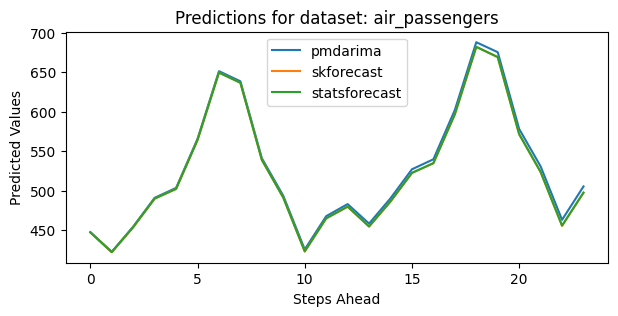

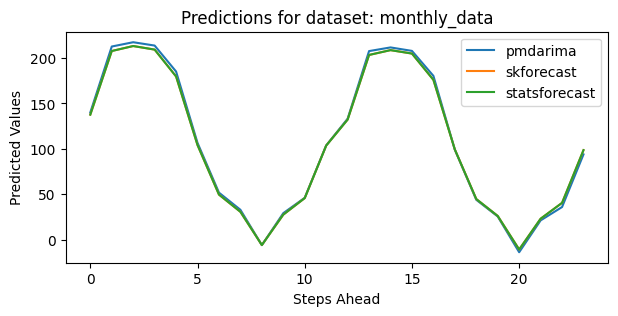

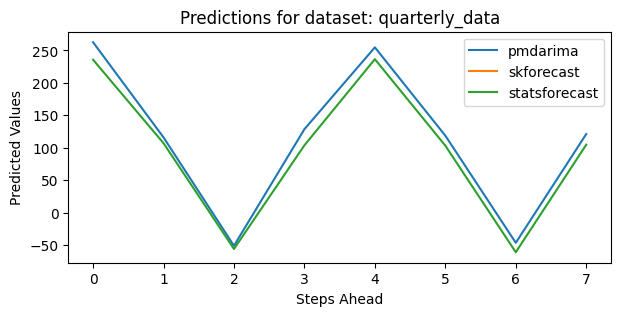

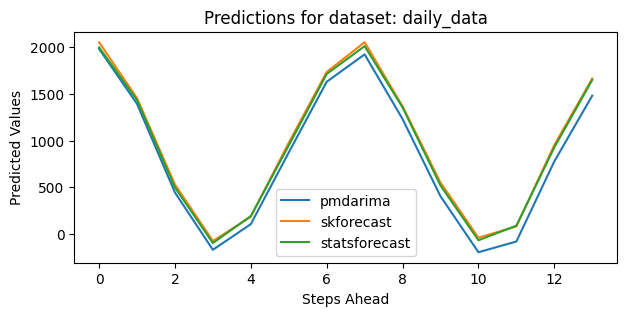

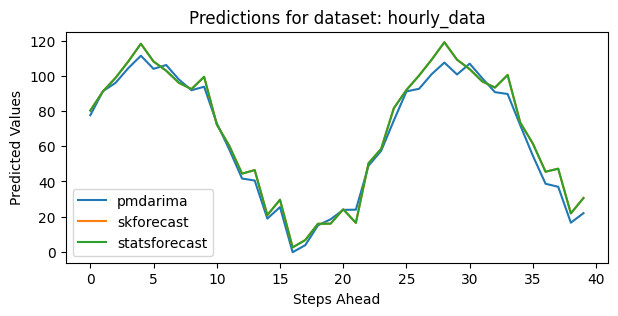

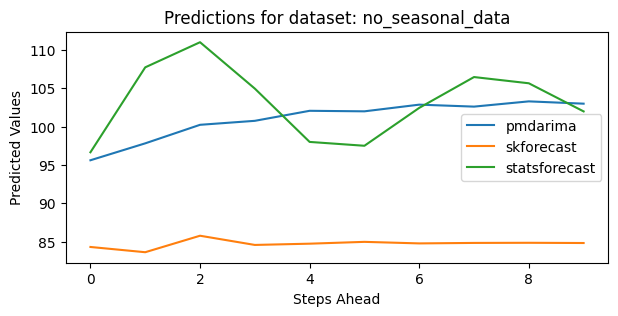

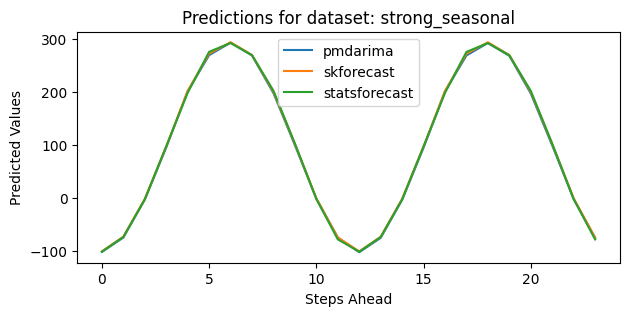

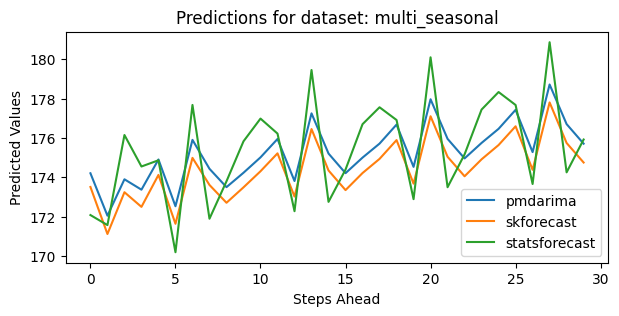

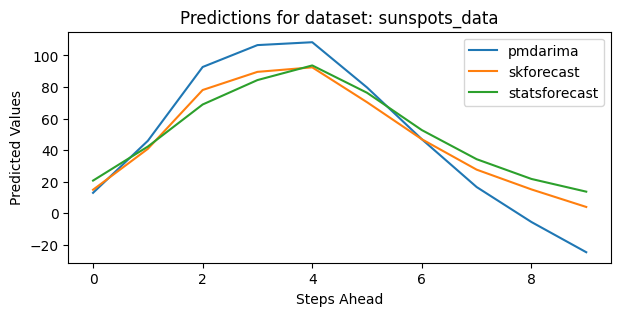

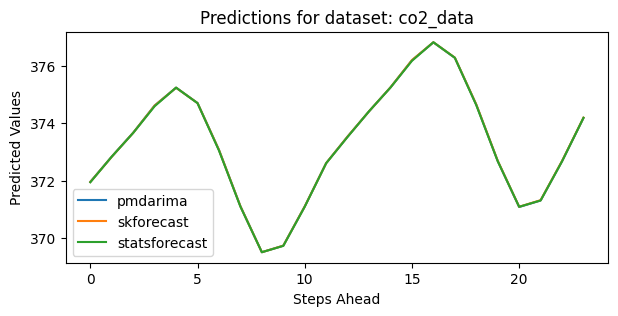

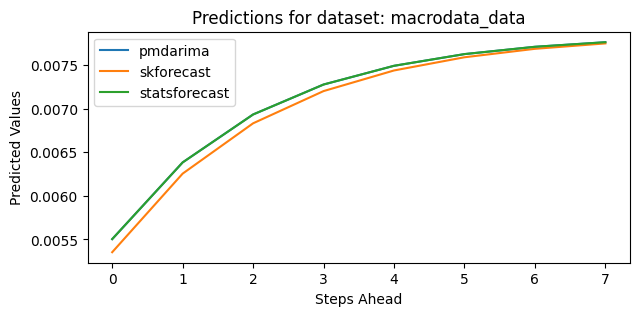

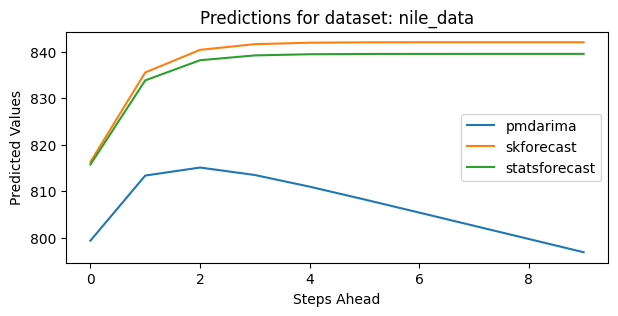

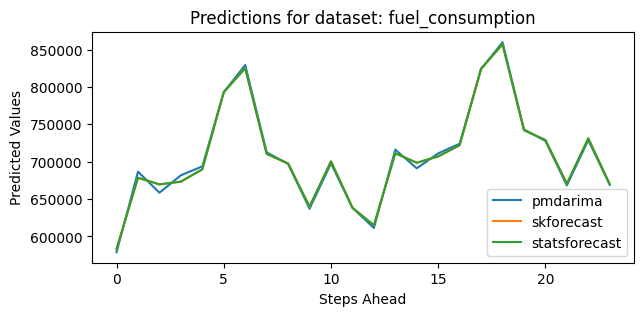

In [110]:
# Plot predictions
# ==============================================================================
import matplotlib.pyplot as plt

for dataset in results_df.index.unique():
    plt.figure(figsize=(7, 3))
    plt.title(f"Predictions for dataset: {dataset}")
    for _, row in results_df.loc[dataset].iterrows():
        plt.plot(
            range(len(row['predictions'])),
            row['predictions'],
            label=row['library']
        )
    plt.xlabel("Steps Ahead")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.show()

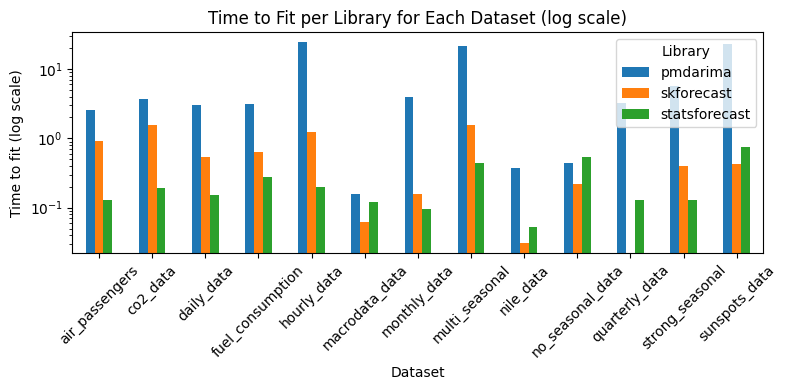

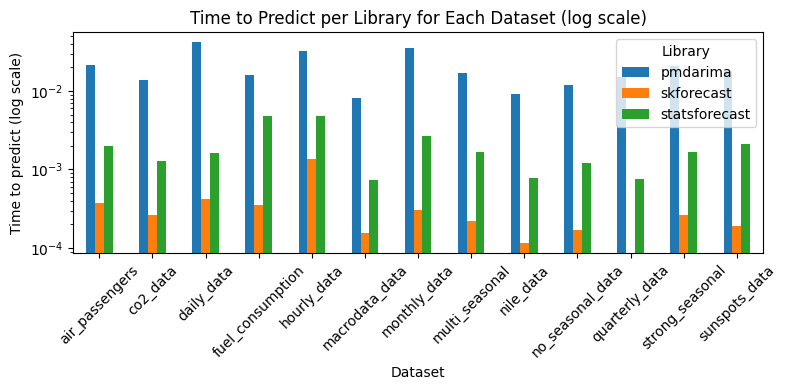

In [111]:
# Plot fitting times
# ==============================================================================
df_plot = results_df.pivot(columns="library", values="time_fit")
ax = df_plot.plot(kind="bar", figsize=(8,4))
plt.yscale("log") 
ax.set_ylabel("Time to fit (log scale)")
ax.set_xlabel("Dataset")
plt.title("Time to Fit per Library for Each Dataset (log scale)")
plt.xticks(rotation=45)
plt.legend(title="Library")
plt.tight_layout()
plt.show()

# Plot prediction times
# ==============================================================================
df_plot = results_df.pivot(columns="library", values="time_pred")
ax = df_plot.plot(kind="bar", figsize=(8,4))
plt.yscale("log") 
ax.set_ylabel("Time to predict (log scale)")
ax.set_xlabel("Dataset")
plt.title("Time to Predict per Library for Each Dataset (log scale)")
plt.xticks(rotation=45)
plt.legend(title="Library")
plt.tight_layout()
plt.show()